In [2]:
%pylab inline --no-import-all
import matplotlib as mpl 
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
# matplotlib.rcParams['axes.grid'] = False
# matplotlib.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set_style('whitegrid')
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

cmap = 'viridis'
par.hdr

Populating the interactive namespace from numpy and matplotlib
../../../../crispy


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

# Construct fake PSF and associated matched filter

1.0
0.0345183948114


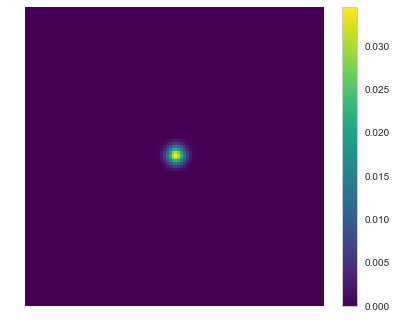

In [3]:
size = 100
FWHM = 5
sigma = FWHM/2.35
threshold=0.2
from scipy.special import erf
x = np.arange(size)-size//2
x,y = np.meshgrid(x,x)
psf = (erf((x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((y - 0.5) / (np.sqrt(2) * sigma)))

psf /= np.sum(psf)

plt.imshow(psf,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

normalized = psf/np.sum(psf)
msk = normalized>np.max(normalized)*threshold
aper_phot = np.sum(normalized)/np.sum(normalized[msk])
normalized[~msk]=0.0
normalized /= np.sum(normalized)


mf = normalized/np.sum(normalized**2)*aper_phot

print np.sum(psf*mf)
print np.amax(psf)
from crispy.tools.image import Image
from crispy.tools.detector import readDetector


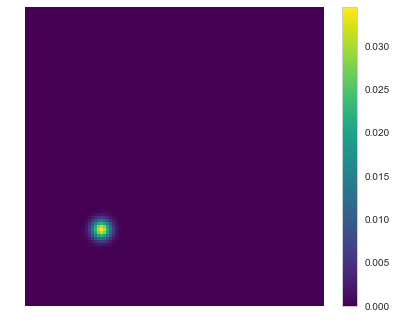

In [38]:
x = np.arange(size)-size//4
x,y = np.meshgrid(x,x)
psf = (erf((x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((y - 0.5) / (np.sqrt(2) * sigma)))

psf /= np.sum(psf)

plt.imshow(psf,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

normalized = psf/np.sum(psf)
msk = normalized>np.max(normalized)*threshold
aper_phot = np.sum(normalized)/np.sum(normalized[msk])
normalized[~msk]=0.0
normalized /= np.sum(normalized)


mf2 = normalized/np.sum(normalized**2)*aper_phot


Flux: 0.014485
Matched filter: 0.014485


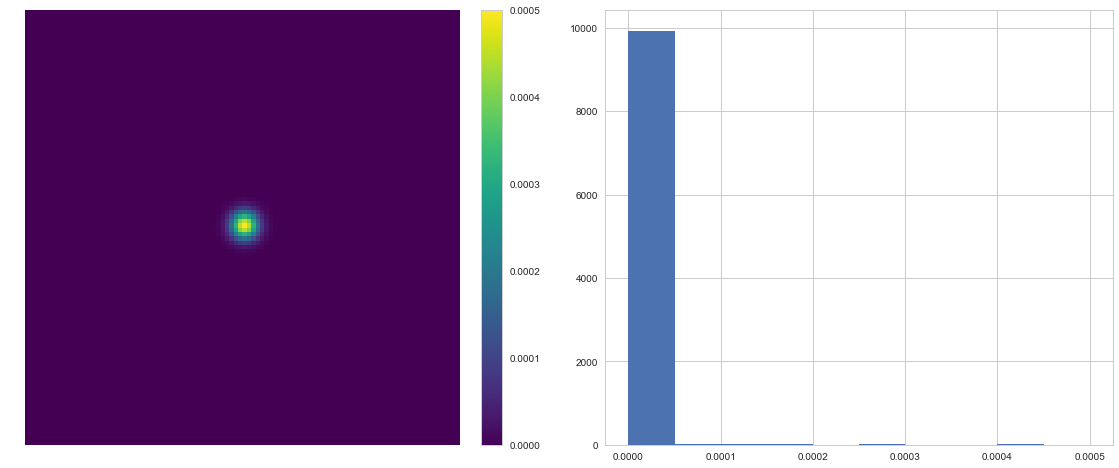

In [4]:
flux = 5e-4/np.amax(psf)
print "Flux: %f" % flux
Nimg = 1000
inttime = 50.
img = psf*flux

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(img,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(img,-1),10)

print "Matched filter: %f" % (np.sum(img*mf))

## Poisson process

0.0005
0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014485 +/- 0.000000


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

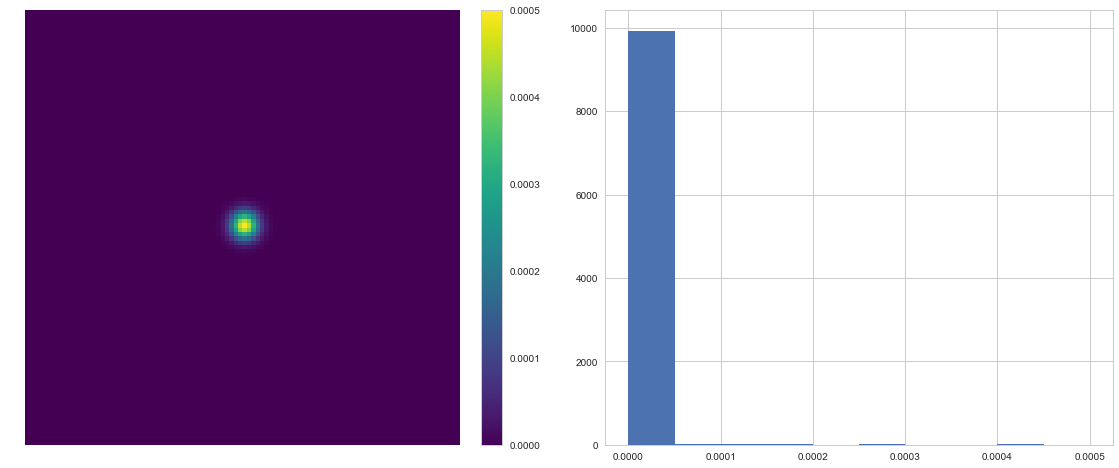

In [5]:
par.losses=1.0
par.nonoise=True
par.poisson=False
par.EMStats=False
par.EMGain = 200.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0
par.dark = 0.0001
par.CIC=0.01

niter = 100
results = np.zeros(niter)
print np.amax(img)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= np.float(Nimg)
#     results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
    results[j] = np.sum((atEMRegister/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))
par.hdr

0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014443 +/- 0.000867


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

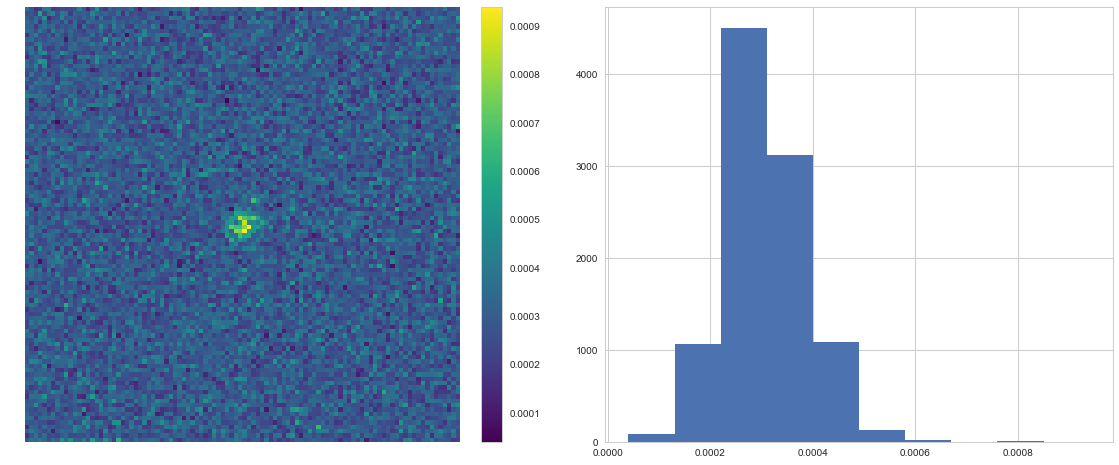

In [6]:
from crispy.tools.image import Image
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=False
par.EMGain = 200.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
#     results[j] = np.sum((atEMRegister/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))
par.hdr

## Electron multiplying stage

0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014449 +/- 0.001323


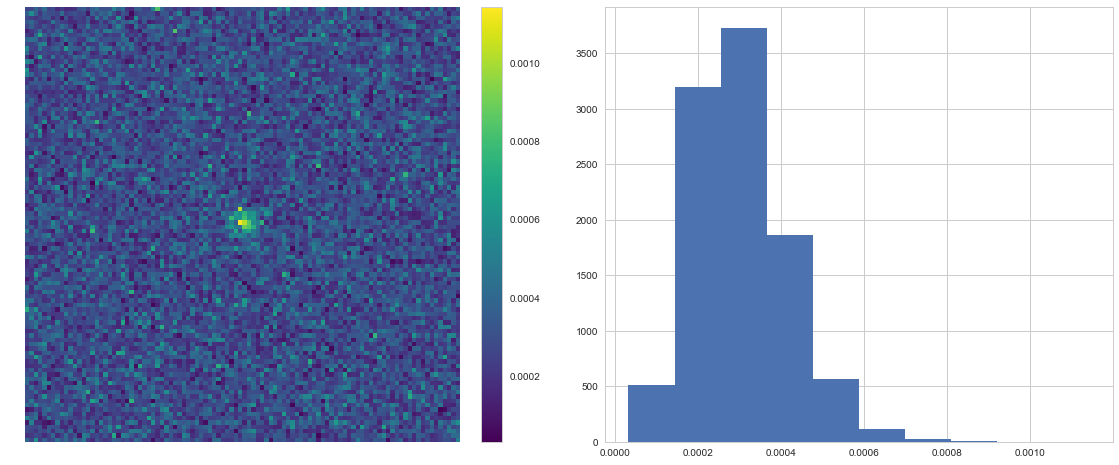

In [7]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2000.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

0
10
20
30
40
50
60
70
80
90
Matched filter: 0.008104 +/- 0.000755


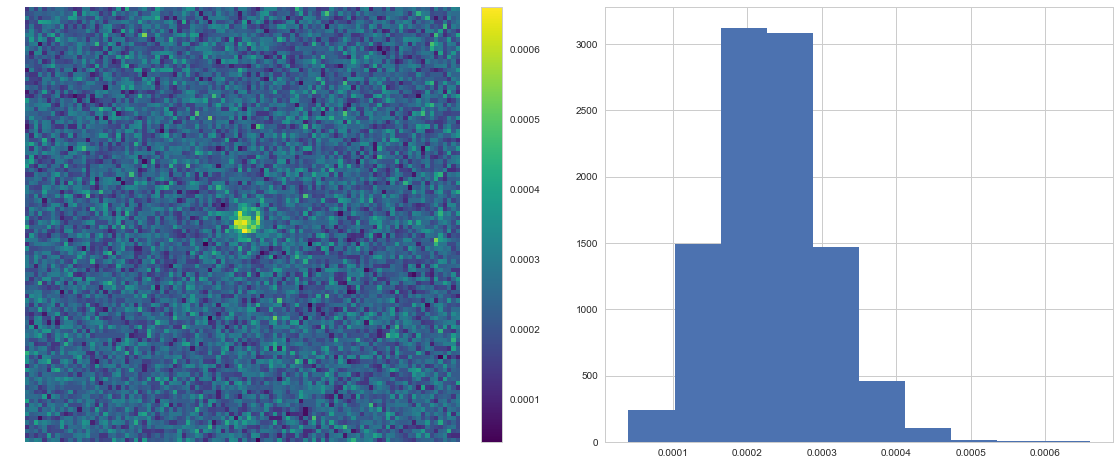

In [11]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2500.0
par.RN=100.0
par.PCbias=0.0
par.PCmode=True
par.threshold = 6.
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

In [45]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2500.0
par.RN=100.0
par.PCbias=2000.0
par.PCmode=True
par.threshold = 5
par.lifefraction = 0.0

niter = 10
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
#     results[j] = np.sum((atEMRegister/inttime)*mf)-np.sum((atEMRegister/inttime)*mf2)
    results[j] = np.sum(((atEMRegister-np.mean(atEMRegister))/inttime)*mf)
#     results[j] = np.sum((atEMRegister/inttime)*mf)

0


Matched filter: 0.011813 +/- 0.000691


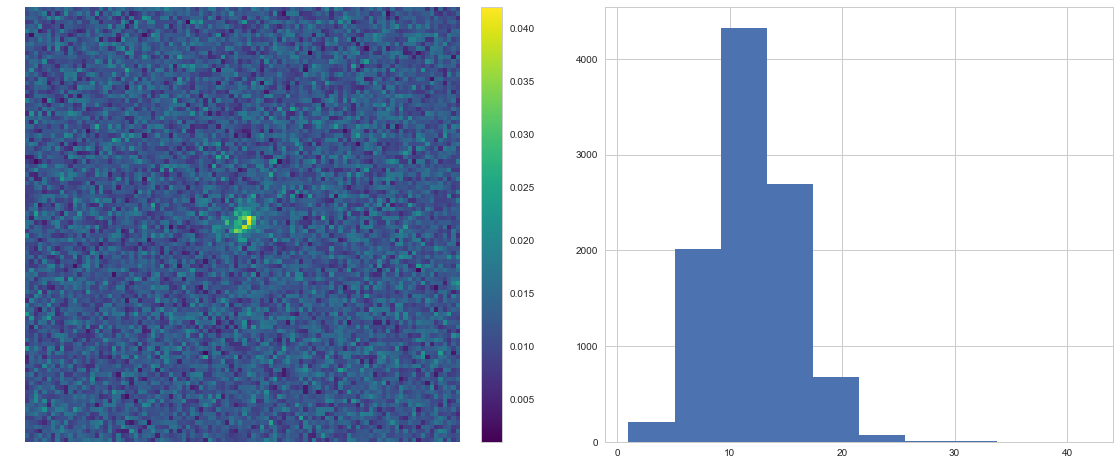

In [46]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister*Nimg,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

In [47]:
np.mean(results)/np.exp(-500./par.EMGain)

0.014428483664780343

In [30]:
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077